# cellules générales, à exécuter en premier

(fonction, import, chargement du dataset)

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, ValidationCurveDisplay, GridSearchCV
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [2]:
common_path = "../chest_Xray/"
images_files = os.listdir(common_path)
subfolders = ["train", "val", "test"]
categories = ["NORMAL", "PNEUMONIA"]


# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
def browse_imgs(img_callback, path_folder_callback=None, limit_size=None):
    for subfolder in subfolders:
        for category in categories:
            # pour avoir tous les chemins des 6 dossiers
            folder_path = os.path.join(common_path, subfolder, category)
            # liste de toutes les images
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            #récupération de toutes les (ou des 'limit_size' premières) images du dossier.
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path, file_name)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                img_callback(img, category)

In [3]:
datasetX = []
datasetY = []

image_size = (200, 200)


def load_datasets(img, category):
    new_img = cv2.resize(img, image_size)
    datasetX.append(new_img)
    datasetY.append(category)


browse_imgs(load_datasets)
datasetX = np.array(datasetX).reshape(-1, image_size[0] * image_size[1])
trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
print("Dataset shape : ", datasetX.shape)

Dataset shape :  (5856, 40000)



# A prendre pour la prochaine fois

la boucle for qui stock les means et std au lieux des res de chaque fold

In [14]:
def cross_val(model, scoring, nb_folds=5):
    res = cross_validate(model, datasetX, datasetY, cv=nb_folds, scoring=scoring, return_train_score=True)
    res.pop("fit_time")
    res.pop("score_time")
    for dataset_key in res:
        mean = res[dataset_key].mean()
        std = res[dataset_key].std()
        res[dataset_key] = {"mean": mean, "std": std}
    return pd.DataFrame(res)

In [5]:
def calcul_and_show_confusion_matrix(model, title="Confusion matrix"):
    model.fit(trainx, trainy)

    y_pred = model.predict(testx)
    recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
    precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
    f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
    print("recall : ", recall)
    print("precision : ", precision)
    print("f1score : ", f1score)

    labels = ["NORMAL", "PNEUMONIA"]
    cm = confusion_matrix(testy, y_pred, labels=labels)
    # change column names from 0, 1 to NORMAL, PNEUMONIA
    cm = pd.DataFrame(cm, columns=labels, index=labels)
    
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

In [6]:
def extract_bests_params_recall_and_precision_from_grid_search(grid_search, instanciate_model_func):
    res = grid_search.cv_results_
    params = grid_search.best_params_.keys()    
    best_recall = np.argmax(res["mean_test_recall"])
    best_precision = np.argmax(res["mean_test_precision"])

    best_recall_params = {}
    for param in params:
        best_recall_params[param] = res["param_" + param][best_recall]
        
    model_recall = instanciate_model_func(**best_recall_params)

    best_precision_params = {}
    for param in params:
        best_precision_params[param] = res["param_" + param][best_precision]
        
    model_precision = instanciate_model_func(**best_precision_params)

    return model_recall, model_precision

In [7]:
general_scoring = {
    "recall": make_scorer(recall_score, pos_label="PNEUMONIA"),
    "precision": make_scorer(precision_score, pos_label="PNEUMONIA"),
    "f1": make_scorer(f1_score, pos_label="PNEUMONIA"),
    "accuracy": "accuracy"
}

# Dummy classifier

In [8]:
model = DummyClassifier(strategy="most_frequent")

scores = cross_val(model, general_scoring)
scores

,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_accuracy,train_accuracy
mean,1.0,1.0,0.729679,0.729679,0.843716,0.843716,0.729679,0.729679
std,0.0,0.0,0.000390,0.000097,0.000261,0.000065,0.000390,0.000097


recall :  1.0
precision :  0.7440273037542662
f1score :  0.8532289628180039


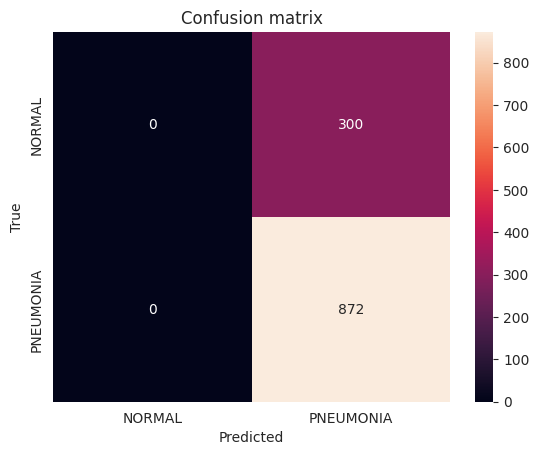

In [9]:
calcul_and_show_confusion_matrix(model)

# comparaison KNN avec 5 et 11 voisins

In [10]:
model = KNeighborsClassifier(n_neighbors=5)

scores = cross_val(model, general_scoring)
scores

,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_accuracy,train_accuracy
mean,0.978467,0.987187,0.900228,0.934849,0.937106,0.960289,0.903172,0.940403
std,0.005577,0.001508,0.041572,0.006990,0.021701,0.003456,0.037124,0.005395


recall :  0.9862385321100917
precision :  0.9188034188034188
f1score :  0.9513274336283186


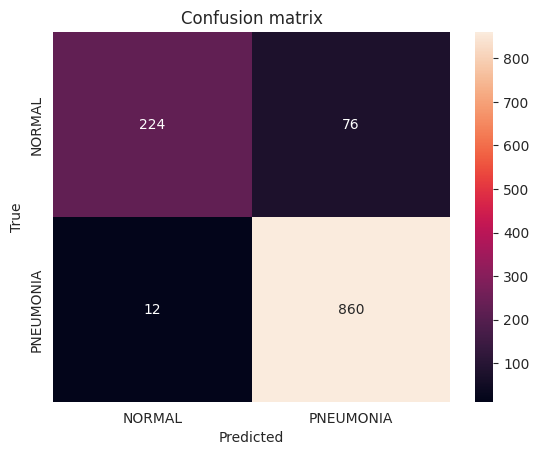

In [11]:
calcul_and_show_confusion_matrix(model)

In [12]:
model = KNeighborsClassifier(n_neighbors=11)

scores = cross_val(model, general_scoring)
scores

,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_accuracy,train_accuracy
mean,0.985490,0.987655,0.902522,0.917930,0.941589,0.951495,0.909662,0.926486
std,0.002298,0.001680,0.044126,0.009084,0.024713,0.005110,0.041763,0.008038


recall :  0.9908256880733946
precision :  0.9133192389006343
f1score :  0.9504950495049505


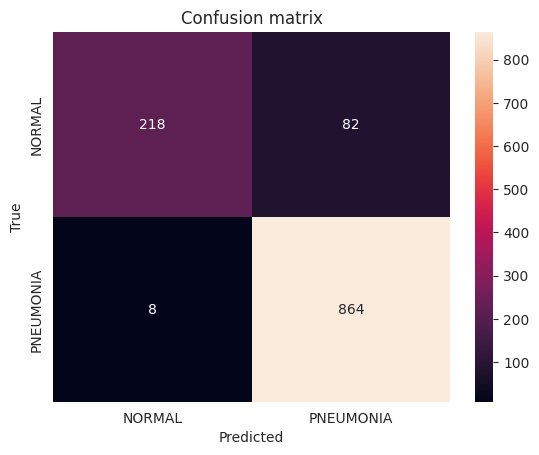

In [13]:
calcul_and_show_confusion_matrix(model)

# grid search sur différents models

## Decision Tree classifier (arbre de décision)

[CV] END .......max_depth=1;, score=(train=0.844, test=0.844) total time=   6.9s
[CV] END .......max_depth=2;, score=(train=0.879, test=0.880) total time=  13.0s
[CV] END .......max_depth=3;, score=(train=0.908, test=0.905) total time=  19.6s
[CV] END .......max_depth=4;, score=(train=0.931, test=0.921) total time=  26.5s
[CV] END .......max_depth=5;, score=(train=0.949, test=0.929) total time=  33.5s
[CV] END .......max_depth=6;, score=(train=0.965, test=0.916) total time=  40.6s
[CV] END .......max_depth=7;, score=(train=0.975, test=0.920) total time=  47.5s
[CV] END .......max_depth=8;, score=(train=0.983, test=0.916) total time=  53.3s
[CV] END .......max_depth=9;, score=(train=0.989, test=0.919) total time=  59.1s
[CV] END .......max_depth=1;, score=(train=0.797, test=0.778) total time=   6.5s
[CV] END .......max_depth=2;, score=(train=0.884, test=0.876) total time=  12.9s
[CV] END .......max_depth=3;, score=(train=0.915, test=0.891) total time=  19.7s
[CV] END .......max_depth=4;

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed: 16.2min


[CV] END .......max_depth=5;, score=(train=0.954, test=0.868) total time=  33.7s
[CV] END .......max_depth=6;, score=(train=0.970, test=0.878) total time=  40.5s
[CV] END .......max_depth=7;, score=(train=0.980, test=0.880) total time=  47.7s
[CV] END .......max_depth=8;, score=(train=0.987, test=0.881) total time=  53.5s
[CV] END .......max_depth=9;, score=(train=0.991, test=0.882) total time=  59.9s


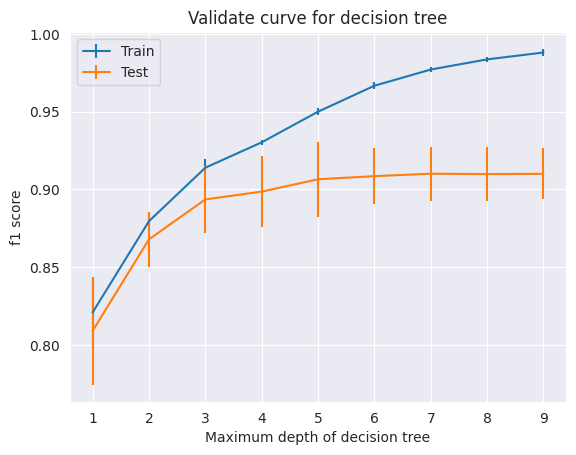

In [14]:
model = DecisionTreeClassifier()

max_depth = np.arange(1, 10, 1)
disp = ValidationCurveDisplay.from_estimator(
    model,
    datasetX,
    datasetY,
    param_name="max_depth",
    param_range=max_depth,
    cv=4,
    score_name="f1",
    scoring=make_scorer(f1_score, pos_label="PNEUMONIA"),
    std_display_style="errorbar",
    verbose=3,
)

_ = disp.ax_.set(
    xlabel="Maximum depth of decision tree",
    ylabel="f1 score",
    title="Validate curve for decision tree",
)

#### Grid search

Fitting 4 folds for each of 45 candidates, totalling 180 fits
[CV 1/4] END max_depth=3, min_samples_leaf=1, min_samples_split=2; accuracy: (train=0.864, test=0.858) f1: (train=0.908, test=0.905) precision: (train=0.892, test=0.886) recall: (train=0.926, test=0.924) total time=  19.7s
[CV 2/4] END max_depth=3, min_samples_leaf=1, min_samples_split=2; accuracy: (train=0.872, test=0.836) f1: (train=0.915, test=0.891) precision: (train=0.888, test=0.868) recall: (train=0.944, test=0.915) total time=  19.7s
[CV 3/4] END max_depth=3, min_samples_leaf=1, min_samples_split=2; accuracy: (train=0.866, test=0.879) f1: (train=0.910, test=0.918) precision: (train=0.892, test=0.906) recall: (train=0.929, test=0.931) total time=  19.7s
[CV 4/4] END max_depth=3, min_samples_leaf=1, min_samples_split=2; accuracy: (train=0.885, test=0.782) f1: (train=0.922, test=0.859) precision: (train=0.910, test=0.814) recall: (train=0.935, test=0.910) total time=  19.6s
[CV 1/4] END max_depth=3, min_samples_leaf=1, 

,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_accuracy,train_accuracy
mean,0.927678,0.983443,0.889126,0.965729,0.907352,0.974471,0.860995,0.962389
std,0.014205,0.005096,0.039120,0.007252,0.019373,0.002483,0.033444,0.003774


recall :  0.9288990825688074
precision :  0.9121621621621622
f1score :  0.9204545454545454


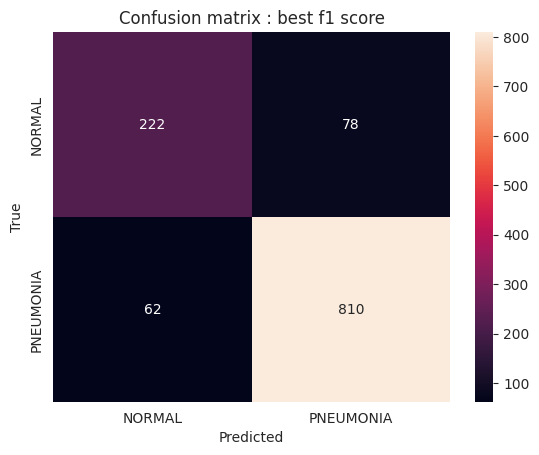

In [15]:
param_grid = {
    "max_depth": np.arange(3, 8, 1),
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

model = DecisionTreeClassifier()
grid_search = GridSearchCV(model, param_grid, cv=4, scoring=general_scoring, refit="f1", verbose=3, return_train_score=True)
grid_search.fit(datasetX, datasetY)

print("best params : ", grid_search.best_params_)

model = grid_search.best_estimator_
print("cross val du model avec le meilleur f1 score")
scores = cross_val(model, general_scoring)
display(scores)

calcul_and_show_confusion_matrix(model, "Confusion matrix : best f1 score")

cross val du model avec le meilleur recall


,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_accuracy,train_accuracy
mean,0.925104,0.983443,0.889593,0.965729,0.906393,0.974471,0.859800,0.962389
std,0.016027,0.005096,0.040054,0.007252,0.021657,0.002483,0.036556,0.003774


recall :  0.9288990825688074
precision :  0.9204545454545454
f1score :  0.9246575342465754


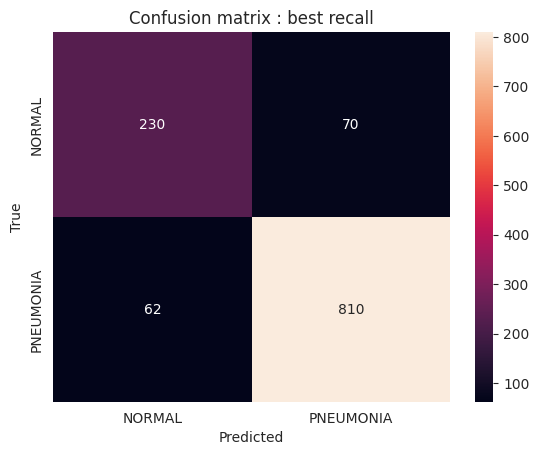

cross val du model avec le meilleur precision


,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_accuracy,train_accuracy
mean,0.924168,0.983501,0.890635,0.965562,0.906442,0.974416,0.859971,0.962304
std,0.014664,0.005055,0.040919,0.007177,0.021146,0.002500,0.036081,0.003796


recall :  0.9231651376146789
precision :  0.9096045197740112
f1score :  0.9163346613545816


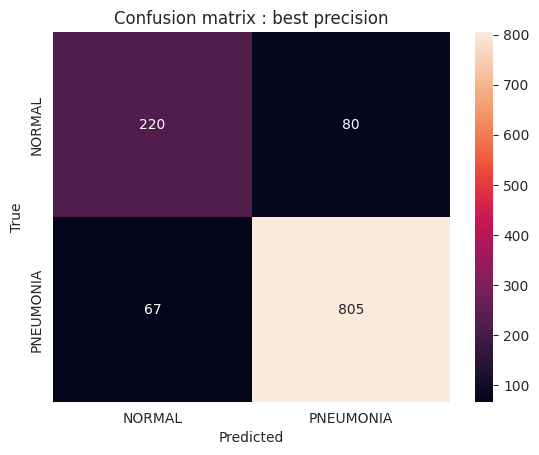

In [16]:
model_recall, model_precision = extract_bests_params_recall_and_precision_from_grid_search(grid_search, DecisionTreeClassifier)

print("cross val du model avec le meilleur recall")
scores = cross_val(model_recall, general_scoring)
display(scores)
calcul_and_show_confusion_matrix(model_recall, "Confusion matrix : best recall")

print("cross val du model avec le meilleur precision")
scores = cross_val(model_precision, general_scoring)
display(scores)
calcul_and_show_confusion_matrix(model_precision, "Confusion matrix : best precision")

## Stochastic Gradient Descent classifier (linear model)

#### Grid search

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic

best params :  {'alpha': 0.01, 'learning_rate': 'optimal', 'loss': 'perceptron', 'penalty': 'l2'}
cross val du model avec le meilleur f1 score


,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_accuracy,train_accuracy
mean,0.926016,0.957414,0.952663,0.990542,0.936212,0.972790,0.907950,0.961834
std,0.058446,0.049823,0.056301,0.013801,0.027218,0.023392,0.040174,0.032033


recall :  0.9552752293577982
precision :  0.9652375434530707
f1score :  0.9602305475504322


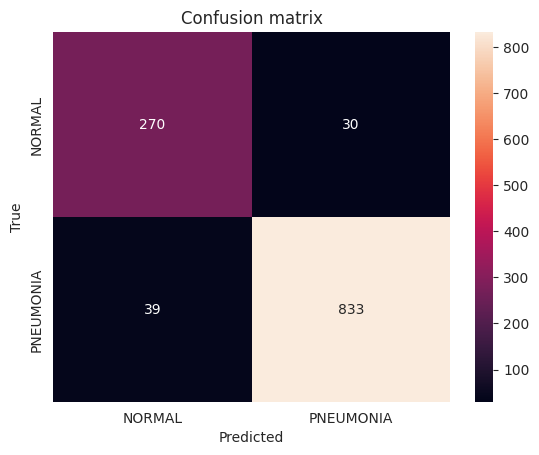

In [8]:
param_grid = {
    "loss": ["hinge", "log_loss", "perceptron"],
    "penalty": ["l2", "l1"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "learning_rate": ["optimal", "invscaling", "adaptive"]
}

model = SGDClassifier(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=4, scoring=general_scoring, refit="f1", return_train_score=True)
grid_search.fit(datasetX, datasetY)

print("best params : ", grid_search.best_params_)
model = grid_search.best_estimator_
scores = cross_val(model, general_scoring)
print("cross val du model avec le meilleur f1 score")
display(scores)

calcul_and_show_confusion_matrix(model)

alpha  :  0.0001
learning_rate  :  invscaling
loss  :  hinge
penalty  :  l2
cross val du model avec le meilleur recall


,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_accuracy,train_accuracy
mean,0.956239,0.989468,0.945653,0.989878,0.949909,0.989616,0.925373,0.984844
std,0.014803,0.007587,0.048414,0.008138,0.020522,0.002454,0.034106,0.003613


recall :  0.9311926605504587
precision :  0.9655172413793104
f1score :  0.9480443666082895


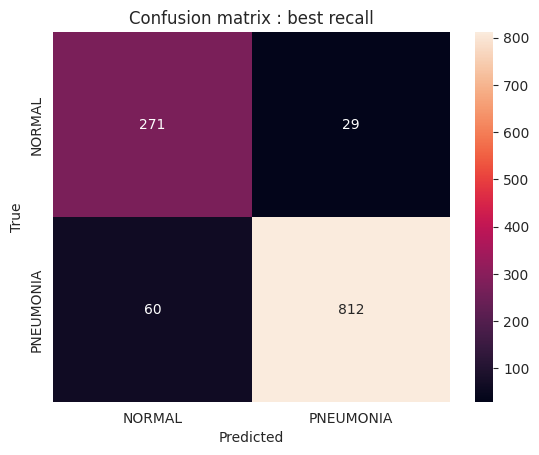

cross val du model avec le meilleur precision


,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_accuracy,train_accuracy
mean,0.958339,0.987422,0.946014,0.987944,0.950818,0.987569,0.926399,0.981899
std,0.020388,0.014141,0.053817,0.009862,0.023263,0.006131,0.038729,0.008818


recall :  0.9587155963302753
precision :  0.9664739884393063
f1score :  0.9625791594703512


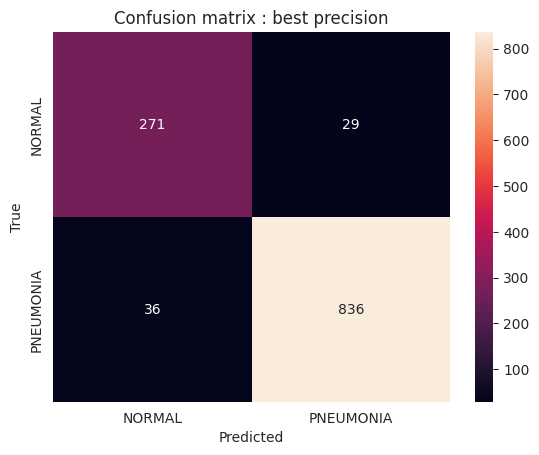

In [12]:
model_recall, model_precision = extract_bests_params_recall_and_precision_from_grid_search(grid_search, SGDClassifier)
# eta0 can't be null 
model_recall.eta0 = 0.01
model_precision.eta0 = 0.01

print("cross val du model avec le meilleur recall")
scores = cross_val(model_recall, general_scoring)
display(scores)
calcul_and_show_confusion_matrix(model_recall, "Confusion matrix : best recall")

print("cross val du model avec le meilleur precision")
scores = cross_val(model_precision, general_scoring)
display(scores)
calcul_and_show_confusion_matrix(model_precision, "Confusion matrix : best precision")

alpha  :  0.0001
learning_rate  :  invscaling
loss  :  hinge
penalty  :  l2
cross val du model avec le meilleur recall


,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_accuracy,train_accuracy
mean,0.956238,0.990931,0.948777,0.992750,0.951257,0.991831,0.927253,0.988089
std,0.017435,0.003184,0.052788,0.003493,0.022255,0.001649,0.037058,0.002413


recall :  0.9793577981651376
precision :  0.9394939493949395
f1score :  0.9590117911285795


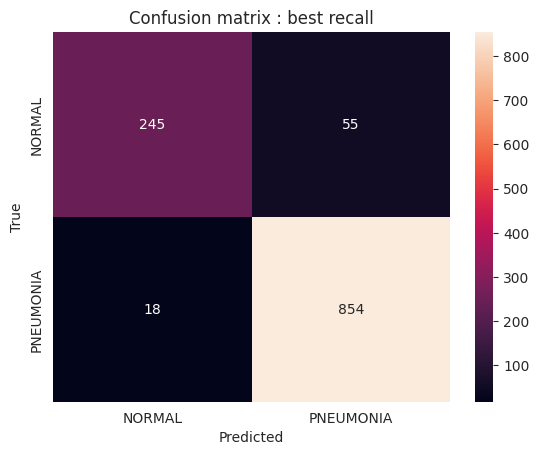

cross val du model avec le meilleur precision


,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_accuracy,train_accuracy
mean,0.956700,0.985725,0.946376,0.989518,0.950411,0.987489,0.926056,0.981856
std,0.018723,0.016668,0.050650,0.007872,0.022940,0.006765,0.037705,0.009596


recall :  0.9678899082568807
precision :  0.9547511312217195
f1score :  0.9612756264236902


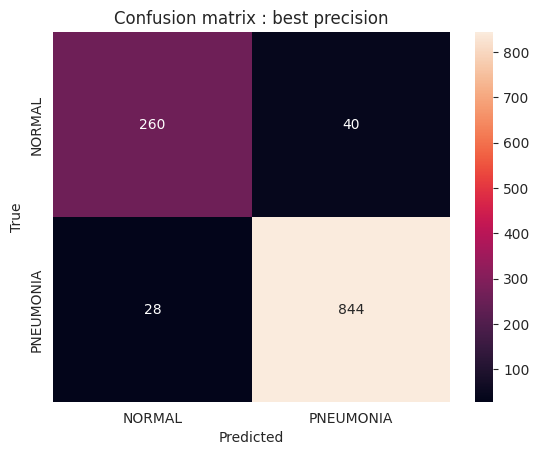

In [13]:
model_recall, model_precision = extract_bests_params_recall_and_precision_from_grid_search(grid_search, SGDClassifier)
# eta0 can't be null 
model_recall.eta0 = 1
model_precision.eta0 = 1

print("cross val du model avec le meilleur recall")
scores = cross_val(model_recall, general_scoring)
display(scores)
calcul_and_show_confusion_matrix(model_recall, "Confusion matrix : best recall")

print("cross val du model avec le meilleur precision")
scores = cross_val(model_precision, general_scoring)
display(scores)
calcul_and_show_confusion_matrix(model_precision, "Confusion matrix : best precision")

## Random Forest classifier (ensemble de décision)

In [ ]:
model = RandomForestClassifier()

max_depth = np.arange(1, 10, 1)
disp = ValidationCurveDisplay.from_estimator(
    model,
    datasetX,
    datasetY,
    param_name="max_depth",
    param_range=max_depth,
    cv=4,
    score_name="f1",
    scoring=make_scorer(f1_score, pos_label="PNEUMONIA"),
    std_display_style="errorbar",
    verbose=3,
)

_ = disp.ax_.set(
    xlabel="Maximum depth of decision tree",
    ylabel="f1 score",
    title="Validate curve for random forest",
)

#### Grid search

In [ ]:
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": np.arange(4, 8, 1),
    "min_samples_split": np.arange(1, 17, 3),
    "min_samples_leaf": np.arange(1, 8, 2)
}

model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=4, scoring=general_scoring, refit="f1", verbose=3, return_train_score=True)
grid_search.fit(datasetX, datasetY)

print("best params : ", grid_search.best_params_)
model = grid_search.best_estimator_
scores = cross_val(model, general_scoring)
print("cross val du model avec le meilleur f1 score")
display(scores)

calcul_and_show_confusion_matrix(model)

In [ ]:
model_recall, model_precision = extract_bests_params_recall_and_precision_from_grid_search(grid_search, RandomForestClassifier)

print("cross val du model avec le meilleur recall")
scores = cross_val(model_recall, general_scoring)
display(scores)
calcul_and_show_confusion_matrix(model_recall, "Confusion matrix : best recall")

print("cross val du model avec le meilleur precision")
scores = cross_val(model_precision, general_scoring)
display(scores)
calcul_and_show_confusion_matrix(model_precision, "Confusion matrix : best precision")

# SGD with max_iter=5000

In [ ]:
param_grid = {
    "loss": ["hinge", "log_loss", "perceptron"],
    "penalty": ["l2", "l1"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "learning_rate": ["optimal", "invscaling", "adaptive"]
}

model = SGDClassifier(max_iter=5000)
grid_search = GridSearchCV(model, param_grid, cv=4, scoring=general_scoring, refit="f1", return_train_score=True, verbose=3)
grid_search.fit(datasetX, datasetY)

print("best params : ", grid_search.best_params_)
model = grid_search.best_estimator_
scores = cross_val(model, general_scoring)
print("cross val du model avec le meilleur f1 score")
display(scores)

calcul_and_show_confusion_matrix(model)

In [ ]:
res = grid_search.cv_results_
params = grid_search.best_params_.keys()    
best_recall = np.argmax(res["mean_test_recall"])
best_precision = np.argmax(res["mean_test_precision"])

best_recall_params = {}
for param in params:
    best_recall_params[param] = res["param_" + param][best_recall]
best_recall_params["max_iter"] = 5000
    
model_recall = SGDClassifier(**best_recall_params)

best_precision_params = {}
for param in params:
    best_precision_params[param] = res["param_" + param][best_precision]
best_precision_params["max_iter"] = 5000

model_precision = SGDClassifier(**best_precision_params)

In [ ]:
print("cross val du model avec le meilleur recall")
scores = cross_val(model_recall, general_scoring)
display(scores)
calcul_and_show_confusion_matrix(model_recall, "Confusion matrix : best recall")

print("cross val du model avec le meilleur precision")
scores = cross_val(model_precision, general_scoring)
display(scores)
calcul_and_show_confusion_matrix(model_precision, "Confusion matrix : best precision")